In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('transfer-learning-pytorch')
jovian.set_colab_id('1RFuKm5AsiWRKy4EzHhqxL1BXu1AIZYdH')

# Transfer Learning for Image Classification in PyTorch

How a CNN learns ([source](https://developer.nvidia.com/discover/convolutional-neural-network)):

![cnn-learning](https://developer.nvidia.com/sites/default/files/pictures/2018/convolutional_neural_network.png)

Layer visualization ([source](https://medium.com/analytics-vidhya/deep-learning-visualization-and-interpretation-of-neural-networks-2f3f82f501c5)):

![cnn-learning](https://miro.medium.com/max/1610/1*WysCJ6Ynecvviwctt6WDlQ.png)


## Downloading the Dataset

We'll use the Oxford-IIIT Pets dataset from https://course.fast.ai/datasets . It is 37 category (breeds) pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. 

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
from torchvision.datasets.utils import download_url

In [ ]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

Using downloaded and verified file: ./oxford-iiit-pet.tgz


In [ ]:
import tarfile

with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
from torch.utils.data import Dataset

In [ ]:
import os

DATA_DIR = './data/oxford-iiit-pet/images'

files = os.listdir(DATA_DIR)
files[:5]

['Bengal_82.jpg',
 'leonberger_29.jpg',
 'Birman_79.jpg',
 'german_shorthaired_37.jpg',
 'Maine_Coon_253.jpg']

In [ ]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

In [ ]:
parse_breed(files[4])

'Maine Coon'

In [ ]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

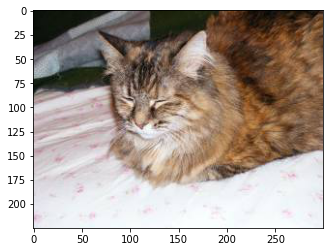

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(open_image(os.path.join(DATA_DIR, (files[4]))))

## Creating a Custom PyTorch Dataset

In [ ]:
import os

class PetsDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes = list(set(parse_breed(fname) for fname in files))
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(parse_breed(fname))
        return img, class_idx

In [ ]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, T.Compose([T.Resize(img_size), 
                                           T.Pad(8, padding_mode='reflect'),
                                           T.RandomCrop(img_size), 
                                           T.ToTensor(), 
                                           T.Normalize(*imagenet_stats)]))

In [ ]:
len(dataset)

7390

In [ ]:
dataset.classes

['British Shorthair',
 'great pyrenees',
 'english cocker spaniel',
 'boxer',
 'shiba inu',
 'beagle',
 'pomeranian',
 'american pit bull terrier',
 'english setter',
 'basset hound',
 'chihuahua',
 'Bombay',
 'german shorthaired',
 'Abyssinian',
 'Siamese',
 'wheaten terrier',
 'Maine Coon',
 'Ragdoll',
 'keeshond',
 'Persian',
 'samoyed',
 'leonberger',
 'Birman',
 'Egyptian Mau',
 'Sphynx',
 'japanese chin',
 'newfoundland',
 'pug',
 'yorkshire terrier',
 'Russian Blue',
 'american bulldog',
 'Bengal',
 'miniature pinscher',
 'saint bernard',
 'havanese',
 'staffordshire bull terrier',
 'scottish terrier']

In [ ]:
len(dataset.classes)

37

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: Birman (22)


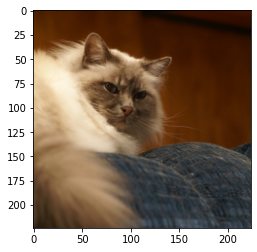

In [ ]:
show_image(*dataset[2])

## Creating Training and Validation Sets

In [ ]:
from torch.utils.data import random_split

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [ ]:
len(train_ds), len(valid_ds)

(6651, 739)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

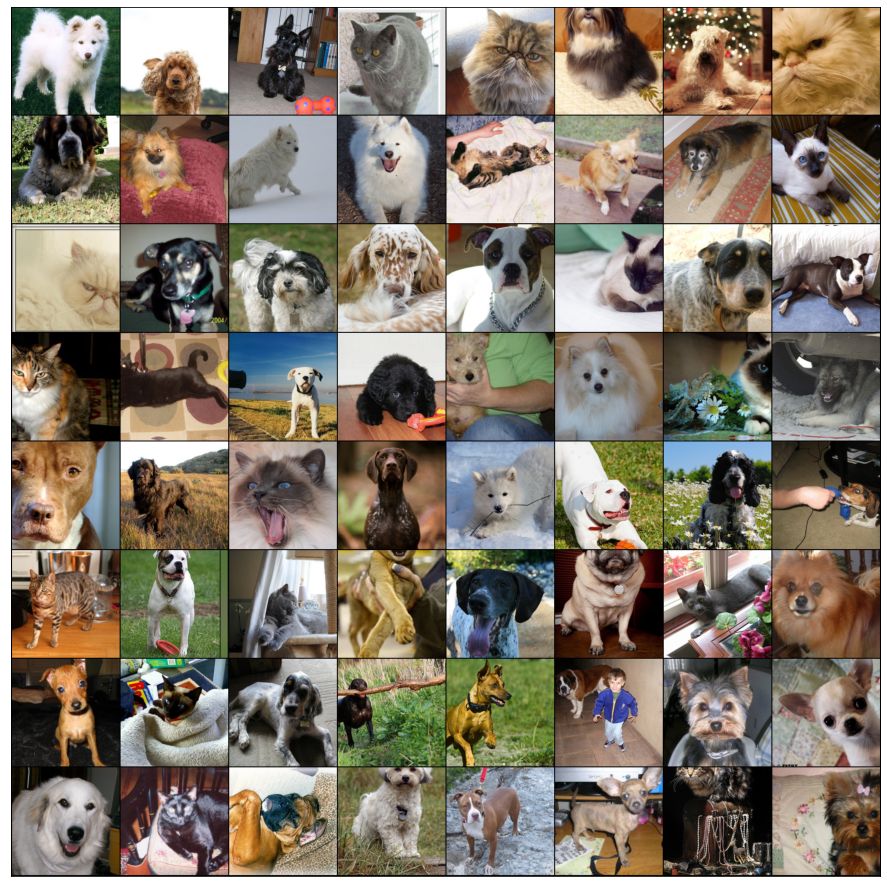

In [ ]:
show_batch(train_dl)

## Modifying a Pretrained Model (ResNet34)

Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


In [ ]:
from torchvision import models

class PetsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
models.resnet34(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## GPU Utilities and Training Loop

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Finetuning the Pretrained Model

In [ ]:
model = PetsModel(len(dataset.classes), pretrained=True)
to_device(model, device);

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.01417091116309166, 'val_loss': 3.955397129058838}]

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00589, train_loss: 1.3658, val_loss: 118.6046, val_acc: 0.0457


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 1.9120, val_loss: 4.7942, val_acc: 0.1014


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 1.2345, val_loss: 2.4547, val_acc: 0.3903


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 0.8488, val_loss: 1.4311, val_acc: 0.5793


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 0.4675, val_loss: 0.6795, val_acc: 0.7746


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.2923, val_loss: 0.5395, val_acc: 0.8389
CPU times: user 1min 9s, sys: 1min 4s, total: 2min 13s
Wall time: 6min 9s


In [ ]:
dir(models)

['AlexNet',
 'DenseNet',
 'EfficientNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'RegNet',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'efficientnet',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'feature_extraction',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'regnet',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 're

## Training a model from scratch 

Let's repeat the training without using weights from the pretrained ResNet34 model.

In [ ]:
model2 = PetsModel(len(dataset.classes), pretrained=False)
to_device(model2, device);

In [ ]:
history2 = [evaluate(model2, valid_dl)]
history2

[{'val_acc': 0.02273196540772915, 'val_loss': 58.863189697265625}]

In [ ]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00589, train_loss: 3.5626, val_loss: 114.5432, val_acc: 0.0240


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 3.4133, val_loss: 5.5536, val_acc: 0.0298


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 3.1810, val_loss: 3.5909, val_acc: 0.0719


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 2.9537, val_loss: 3.5023, val_acc: 0.0978


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 2.7150, val_loss: 2.8781, val_acc: 0.2119


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 2.4817, val_loss: 2.6092, val_acc: 0.2530
CPU times: user 1min 10s, sys: 1min 5s, total: 2min 16s
Wall time: 6min 4s


While the pretrained model reached an accuracy of 80% in less than 3 minutes, the model without pretrained weights could only reach an accuracy of 24%.

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.commit(project='transfer-learning-pytorch')

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/rick101001/transfer-learning-pytorch


'https://jovian.ai/rick101001/transfer-learning-pytorch'